In [26]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [53]:
import json
import json_repair

from typing import List, Dict
from colorama import Fore

from haystack import component, Pipeline
from haystack.dataclasses import Document

from haystack.components.embedders import OpenAITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.embedders import OpenAIDocumentEmbedder
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.writers import DocumentWriter

ModuleNotFoundError: No module named 'json_repair'

## Components
1. Initialize a component
2. Inspect expected input/output types

In [28]:
embedder = OpenAIDocumentEmbedder(model="text-embedding-3-small")

In [29]:
embedder

Inputs:
  - documents: List[Document]
Outputs:
  - documents: List[Document]
  - meta: Dict[str, Any]

In [30]:
documents = [Document(content="Haystack is an open source AI framework to build full AI applications in Python"),
             Document(content="You can build AI Pipelines by combining Components"),]

embedder.run(documents=documents)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


{'documents': [Document(id=cca6283a4f41557c49df1c5087a6be0ec172815a8d0c811e435caf6b1a93e0b4, content: 'Haystack is an open source AI framework to build full AI applications in Python', embedding: vector of size 1536),
  Document(id=11ee1490e1dc5cd44361b1541008891b0b40aabd4d5bb2da6a2499f23e6120f7, content: 'You can build AI Pipelines by combining Components', embedding: vector of size 1536)],
 'meta': {'model': 'text-embedding-3-small',
  'usage': {'prompt_tokens': 24, 'total_tokens': 24}}}

## Pipelines (Indexing + RAG Pipelines)

1. Add components
2. Connect components

In [31]:
document_store = InMemoryDocumentStore()
document_store.count_documents()

0

In [32]:
fetcher = LinkContentFetcher()
converter = HTMLToDocument()
embedder = OpenAIDocumentEmbedder()
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("fetcher", fetcher)
indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

In [33]:
indexing_pipeline.connect("fetcher", "converter")
indexing_pipeline.connect("converter", "embedder")
indexing_pipeline.connect("embedder", "writer")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - embedder: OpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

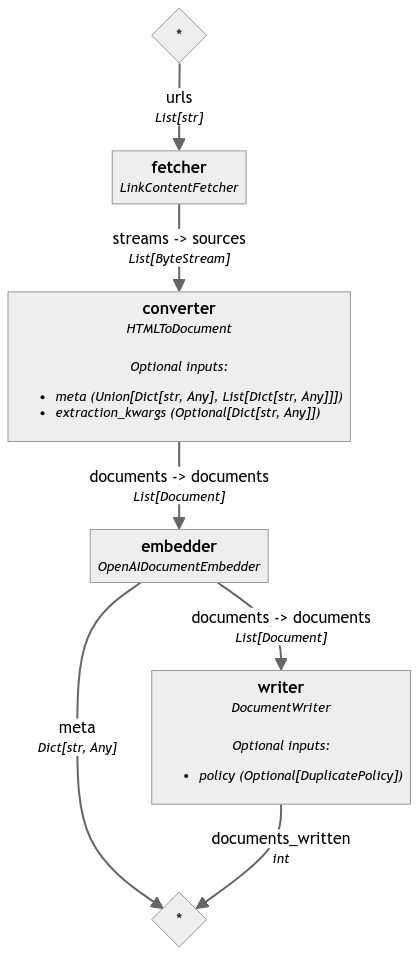

In [34]:
indexing_pipeline.show()

In [35]:
indexing_pipeline.run({"fetcher": {"urls": ["https://haystack.deepset.ai/integrations/mistral", 
                                            "https://haystack.deepset.ai/integrations/cohere"]}})

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


{'embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 3075, 'total_tokens': 3075}}},
 'writer': {'documents_written': 2}}

In [36]:
document_store.count_documents()

2

### RAG

In [45]:
prompt_template = """Answer the question given the following documents. 
Documents:
{% for document in documents %}
    {{document.content}}
{% endfor %}
Question: {{query}}
Answer:
 """

In [46]:
query_embedder = OpenAITextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt = PromptBuilder(template=prompt_template)
llm = OpenAIGenerator(model="gpt-4")

rag = Pipeline()

rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt)
rag.add_component("llm", llm)


rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "llm")

🚅 Components
  - query_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [48]:
query = "What are the available Jina components?"
rag.run({"query_embedder": {"text": query},
         "prompt": {"query": query}})

{'query_embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 8, 'total_tokens': 8}}},
 'llm': {'replies': ['The available Jina components are not mentioned in the provided documents. The documents mention Mistral AI and Cohere components that can be used with Haystack, including MistralDocumentEmbedder, MistralTextEmbedder, MistralChatGenerator, CohereTextEmbedder, CohereDocumentEmbedder, CohereGenerator, and CohereRanker, but they do not provide any information about Jina components.'],
  'meta': [{'model': 'gpt-4-0613',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 83,
     'prompt_tokens': 3266,
     'total_tokens': 3349}}]}}

## Self Reflection - Entity Extraction

In [49]:
template = """"Extract entities from the following text
Text: {{ text }} 
The entities should be presented as key value pairs in a JSON object.

{% if entites_to_validate %}
    Here are the entities you extracted: {{entites_to_validate[0]}}
    Have you extracted all possible entities? 
    If yes, say 'done' and return the extracted entites in the next line
    If not, say 'incomplete' and return the entities in the next line
{% endif %}
Entities:
"""

In [50]:
@component
class EntitiesValidator:
    
    @component.output_types(entites_to_validate=str, entities=str)
    def run(self, replies: List[str]):
        if 'done' in replies[0]:
            return {"entities":replies[0].replace('done', '')}
        else:
            print(Fore.RED + "Entities to Validate\n", replies[0])
            return {"entites_to_validate": replies[0]}

In [51]:
prompt_template = PromptBuilder(template=template)
llm = OpenAIGenerator()
entities_validator = EntitiesValidator()

pipeline = Pipeline(max_loops_allowed=10)

pipeline.add_component("prompt_builder", prompt_template)
pipeline.add_component("entities_validator", entities_validator)
pipeline.add_component("llm", llm)

pipeline.connect("prompt_builder.prompt", "llm.prompt")
pipeline.connect("llm.replies", "entities_validator.replies")
pipeline.connect("entities_validator.entites_to_validate", "prompt_builder.entites_to_validate")

🚅 Components
  - prompt_builder: PromptBuilder
  - entities_validator: EntitiesValidator
  - llm: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - entities_validator.entites_to_validate -> prompt_builder.entites_to_validate (str)
  - llm.replies -> entities_validator.replies (List[str])

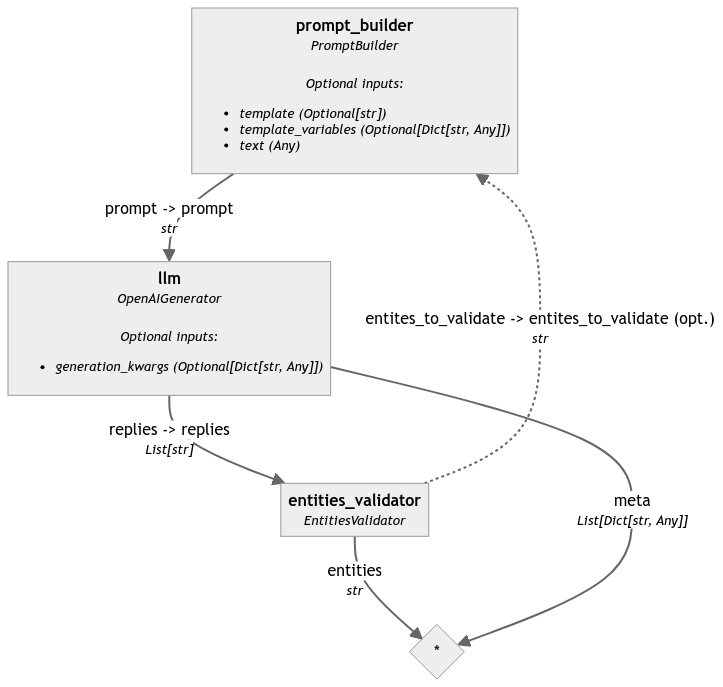

In [52]:
pipeline.show()

In [25]:
text = """
June 19-20, 2024
Paris, France
Composing AI Applications as a Graph with Haystack - Tuana Celik, deepset
There are many moving parts in a fully functioning AI application, whether that be retrieval-augmented generation, agents, chatbots.. Haystack is an open source AI framework in Python, recently redesigned in an opinionated way, that takes the approach of building AI applications as a directed (cyclic) graph. In this talk, we will see how Haystack allows engineers to take full control over how they design their AI workflows, making use of pretty much all model providers and technologies out there.
Speakers
Tuana Celik
Developer Relations Lead, deepset
Tuana is a Developer Advocate at deepset where she focuses on the open source AI community and Haystack, deepset’s open source AI framework. She has been actively involved in helping and maintaining the Haystack developer community and Haystack’s educational materials.
"""

result = pipeline.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Entities to Validate
 {
  "Date": "June 19-20, 2024",
  "Location": "Paris, France",
  "Topic": "Composing AI Applications as a Graph with Haystack",
  "Speaker": "Tuana Celik",
  "Company": "deepset",
  "Role": "Developer Relations Lead",
  "Framework": "Haystack",
  "Language": "Python"
}
{
    "Date": "June 19-20, 2024",
    "Location": "Paris, France",
    "Topic": "Composing AI Applications as a Graph with Haystack",
    "Speaker": "Tuana Celik",
    "Company": "deepset",
    "Role": "Developer Relations Lead",
    "Framework": "Haystack",
    "Programming Language": "Python"
}




In [ ]:
@component
class QuizParser:
    @component.output_types(quiz=Dict)
    def run(self, replies: List[str]):
        reply = replies[0]

        # even if prompted to respond with JSON only, sometimes the model returns a mix of JSON and text
        first_index = min(reply.find("{"), reply.find("["))
        last_index = max(reply.rfind("}"), reply.rfind("]")) + 1

        json_portion = reply[first_index:last_index]

        try:
            quiz = json.loads(json_portion)
        except json.JSONDecodeError:
            # if the JSON is not well-formed, try to repair it
            quiz = json_repair.loads(json_portion)

        # sometimes the JSON contains a list instead of a dictionary
        if isinstance(quiz, list):
            quiz = quiz[0]

        print(quiz)

        return {"quiz": quiz}